In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn

In [2]:
data = pd.read_csv('data.csv')
data

,Date,USD,EUR,CNY,RUB
0,01.01.2000,138.20,143.65,16.69,5.03
1,02.01.2000,138.20,143.65,16.69,5.03
2,03.01.2000,138.20,143.65,16.69,5.03
3,04.01.2000,138.20,143.65,16.69,5.03
4,05.01.2000,138.20,146.55,16.69,5.03
...,...,...,...,...,...
9081,03.12.2024,524.58,551.91,72.13,4.93
9082,04.12.2024,523.17,550.06,71.81,4.93
9083,05.12.2024,523.58,549.71,71.99,5.01
9084,06.12.2024,524.65,552.19,72.23,5.14


In [3]:
data = data[['Date', 'USD']]
data.dtypes

Date     object
USD     float64
dtype: object

In [4]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)

/tmp/ipykernel_51905/1887270223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)


In [5]:
data.isnull().sum()

USD    0
dtype: int64

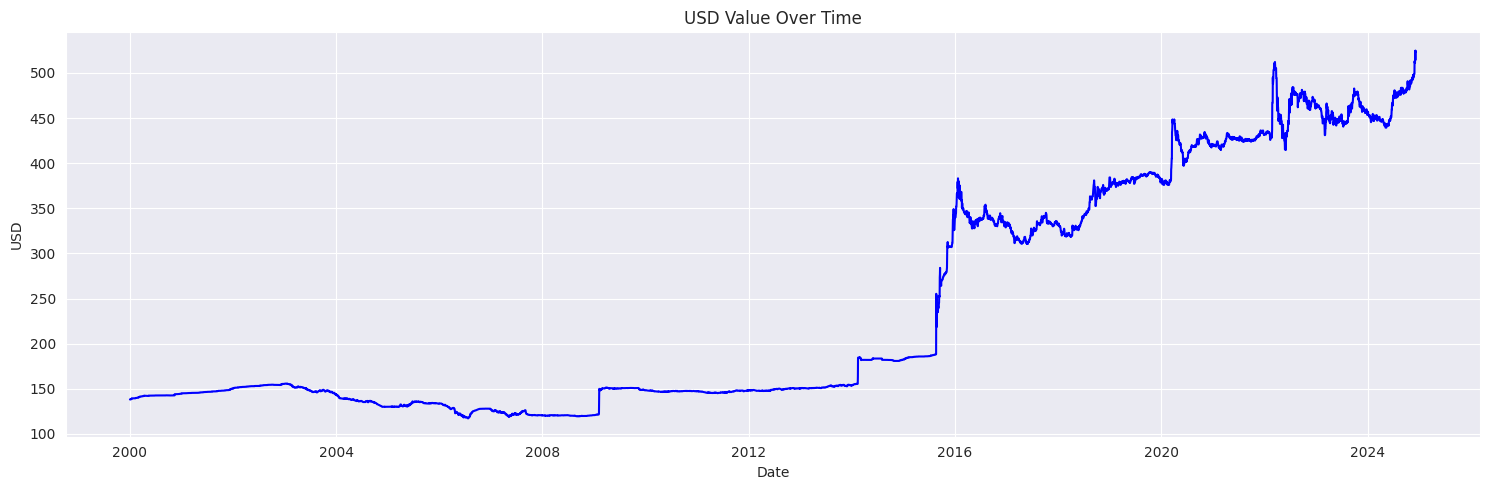

In [6]:
mon = data[(data.index >= '2023-01-01') & (data.index < '2024-01-01')]

plt.figure(figsize=(15, 5))
plt.plot(data.index, data['USD'], linestyle='-', color='blue')
plt.title('USD Value Over Time')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['USD'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("Stationary (reject H₀)")
else:
    print("Non-Stationary (fail to reject H₀)")

ADF Statistic: 0.7934229232545603
p-value: 0.991529256477285
Non-Stationary (fail to reject H₀)


In [8]:
data['USDdiff'] = data['USD'].diff().dropna()
data

/tmp/ipykernel_51905/3427961056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['USDdiff'] = data['USD'].diff().dropna()


,USD,USDdiff
Date,,
2000-01-01,138.20,NaN
2000-01-02,138.20,0.00
2000-01-03,138.20,0.00
2000-01-04,138.20,0.00
2000-01-05,138.20,0.00
...,...,...
2024-12-03,524.58,13.36
2024-12-04,523.17,-1.41
2024-12-05,523.58,0.41


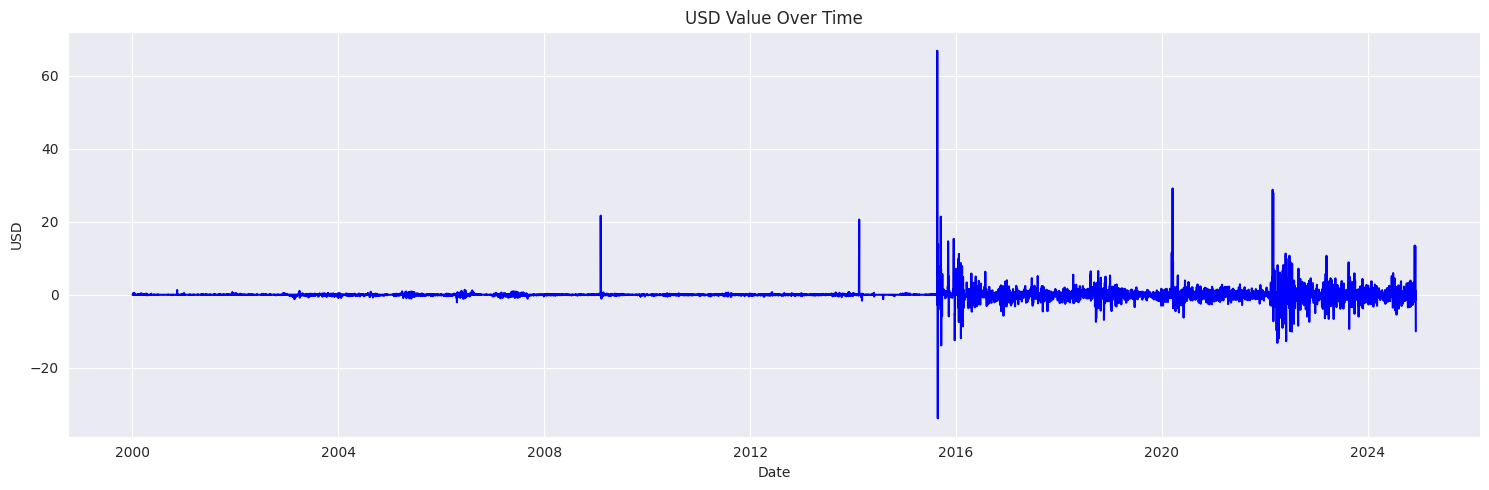

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['USDdiff'], linestyle='-', color='blue')
plt.title('USD Value Over Time')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
result = adfuller(data['USD'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("Stationary (reject H₀)")
else:
    print("Non-Stationary (fail to reject H₀)")

ADF Statistic: 0.7934229232545603
p-value: 0.991529256477285
Non-Stationary (fail to reject H₀)


In [11]:
origin = data['USD']
data = data['USDdiff']

In [12]:
data

Date
2000-01-01      NaN
2000-01-02     0.00
2000-01-03     0.00
2000-01-04     0.00
2000-01-05     0.00
              ...  
2024-12-03    13.36
2024-12-04    -1.41
2024-12-05     0.41
2024-12-06     1.07
2024-12-07   -10.00
Name: USDdiff, Length: 9086, dtype: float64

In [13]:
split = int(len(data) * 0.8)
train, test = data[:split], data[split:]

In [14]:
print(train.diff().dropna().describe())

count    7266.000000
mean        0.000000
std         1.826804
min       -69.670000
25%        -0.060000
50%         0.000000
75%         0.070000
max        66.850000
Name: USDdiff, dtype: float64


In [15]:
origin.value_counts()

USD
142.65    63
185.80    45
142.70    42
180.87    40
182.00    37
          ..
181.34     1
181.52     1
183.28     1
513.00     1
499.51     1
Name: count, Length: 3645, dtype: int64

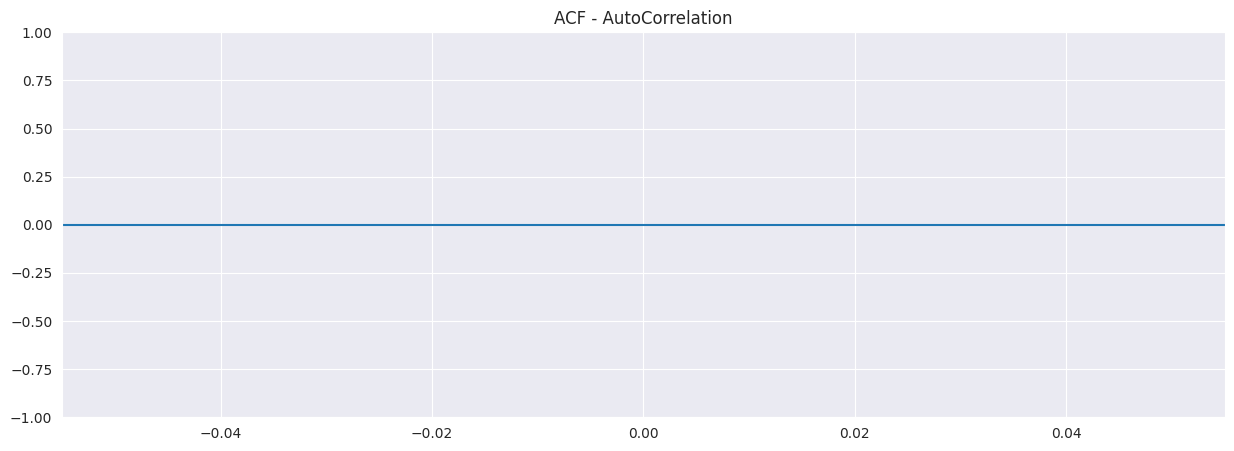

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(train, lags=500, ax=ax)
ax.set_title('ACF - AutoCorrelation')
plt.show()

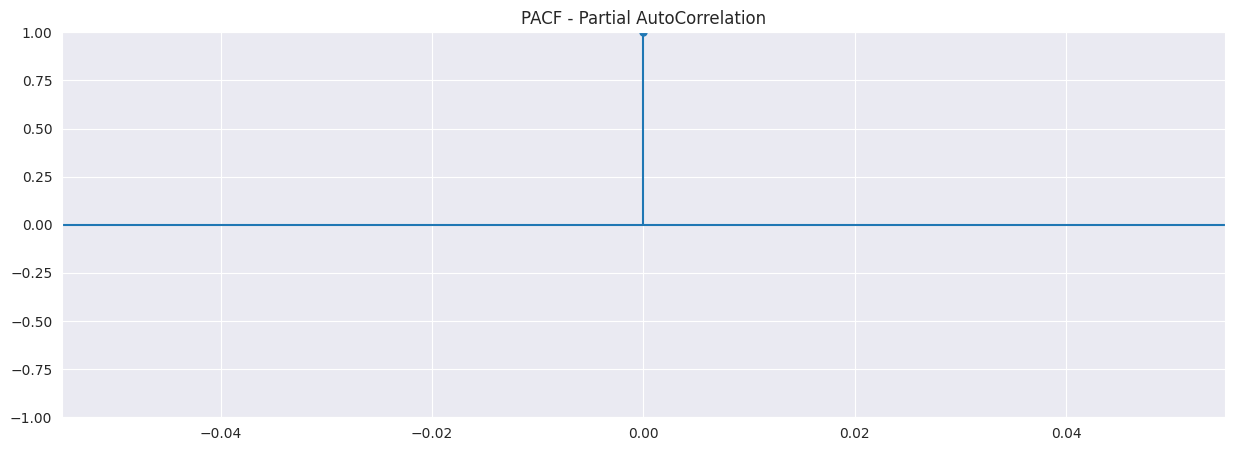

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(train, lags=30, ax=ax)
ax.set_title('PACF - Partial AutoCorrelation')
plt.show()

In [18]:
test

Date
2019-12-17     0.00
2019-12-18     0.00
2019-12-19     0.45
2019-12-20     0.06
2019-12-21    -1.47
              ...  
2024-12-03    13.36
2024-12-04    -1.41
2024-12-05     0.41
2024-12-06     1.07
2024-12-07   -10.00
Name: USDdiff, Length: 1818, dtype: float64

In [19]:
model = ARIMA(train, order=(0,0,0))
model_fit = model.fit()

/home/yeaz/PycharmProjects/Science/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yeaz/PycharmProjects/Science/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yeaz/PycharmProjects/Science/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [20]:
forecast = model_fit.forecast(steps=10)
forecast

/home/yeaz/PycharmProjects/Science/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/yeaz/PycharmProjects/Science/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


7268    0.033812
7269    0.033812
7270    0.033812
7271    0.033812
7272    0.033812
7273    0.033812
7274    0.033812
7275    0.033812
7276    0.033812
7277    0.033812
Name: predicted_mean, dtype: float64

In [21]:
month = train[-30:]

/home/yeaz/PycharmProjects/Science/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/yeaz/PycharmProjects/Science/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


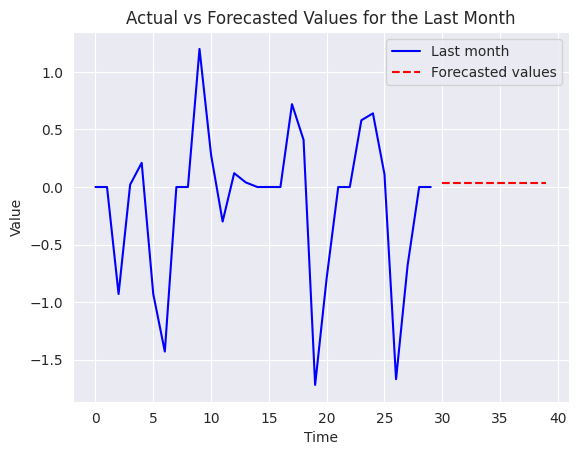

In [22]:
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

actual_x = range(len(month))

forecast_x = range(len(month), len(month) + forecast_steps)

plt.plot(actual_x, month, label="Last month", color='blue')

plt.plot(forecast_x, forecast, label="Forecasted values", color='red', linestyle='--')

plt.title('Actual vs Forecasted Values for the Last Month')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [24]:
def create_sequences(data, steps):
    for i in range(1, steps + 1):
        data[f'USD(t-{i})'] = data['USD'].shift(i)

    data.dropna(inplace=True)
    return data

In [25]:
data = pd.read_csv('data.csv')
data = data[['Date', 'USD']]
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)
data

,USD
Date,
2000-01-01,138.20
2000-01-02,138.20
2000-01-03,138.20
2000-01-04,138.20
2000-01-05,138.20
...,...
2024-12-03,524.58
2024-12-04,523.17
2024-12-05,523.58


In [26]:
lookback = 15
data = create_sequences(data, lookback)

In [27]:
data

,USD,USD(t-1),USD(t-2),USD(t-3),USD(t-4),USD(t-5),USD(t-6),USD(t-7),USD(t-8),USD(t-9),USD(t-10),USD(t-11),USD(t-12),USD(t-13),USD(t-14),USD(t-15)
Date,,,,,,,,,,,,,,,,
2000-01-16,139.40,139.40,138.95,138.95,138.95,138.70,138.70,138.70,138.70,138.20,138.20,138.20,138.20,138.20,138.20,138.20
2000-01-17,139.40,139.40,139.40,138.95,138.95,138.95,138.70,138.70,138.70,138.70,138.20,138.20,138.20,138.20,138.20,138.20
2000-01-18,139.40,139.40,139.40,139.40,138.95,138.95,138.95,138.70,138.70,138.70,138.70,138.20,138.20,138.20,138.20,138.20
2000-01-19,139.50,139.40,139.40,139.40,139.40,138.95,138.95,138.95,138.70,138.70,138.70,138.70,138.20,138.20,138.20,138.20
2000-01-20,139.50,139.50,139.40,139.40,139.40,139.40,138.95,138.95,138.95,138.70,138.70,138.70,138.70,138.20,138.20,138.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03,524.58,511.22,511.22,511.22,513.00,499.51,498.55,498.51,498.34,498.34,498.34,494.87,495.20,497.26,497.89,495.95
2024-12-04,523.17,524.58,511.22,511.22,511.22,513.00,499.51,498.55,498.51,498.34,498.34,498.34,494.87,495.20,497.26,497.89
2024-12-05,523.58,523.17,524.58,511.22,511.22,511.22,513.00,499.51,498.55,498.51,498.34,498.34,498.34,494.87,495.20,497.26


In [28]:
X = data.drop(columns=['USD'])
y = data['USD']

In [29]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

In [31]:
X_train = X_train.reshape((X_train.shape[0], lookback, 1))
X_test = X_test.reshape((X_test.shape[0], lookback, 1))

In [32]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [33]:
class TimeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        return self.X[item], self.y[item]

In [34]:
train_dataset = TimeDataset(torch.tensor(X_train, dtype=torch.float32),
                            torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))

test_dataset = TimeDataset(torch.tensor(X_test, dtype=torch.float32),
                           torch.tensor(y_test, dtype=torch.float32).unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [35]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

In [36]:
input_size = 1
hidden_size = 64
num_layers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTM(input_size, hidden_size, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train_loader):.4f}")


/home/yeaz/PycharmProjects/Science/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/yeaz/PycharmProjects/Science/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 1, 1])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 0.0028
Epoch 2/20, Loss: 0.0145
Epoch 3/20, Loss: 0.0198
Epoch 4/20, Loss: 0.0219
Epoch 5/20, Loss: 0.0178
Epoch 6/20, Loss: 0.0088
Epoch 7/20, Loss: 0.0025
Epoch 8/20, Loss: 0.0006
Epoch 9/20, Loss: 0.0003
Epoch 10/20, Loss: 0.0003
Epoch 11/20, Loss: 0.0002
Epoch 12/20, Loss: 0.0002
Epoch 13/20, Loss: 0.0002
Epoch 14/20, Loss: 0.0002
Epoch 15/20, Loss: 0.0002
Epoch 16/20, Loss: 0.0002
Epoch 17/20, Loss: 0.0002
Epoch 18/20, Loss: 0.0002
Epoch 19/20, Loss: 0.0003
Epoch 20/20, Loss: 0.0003


In [38]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(X_batch)
        predictions.extend(output.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())


In [39]:
predictions_flat = np.array(predictions).reshape(-1)
actuals_flat = np.array(actuals).reshape(-1)

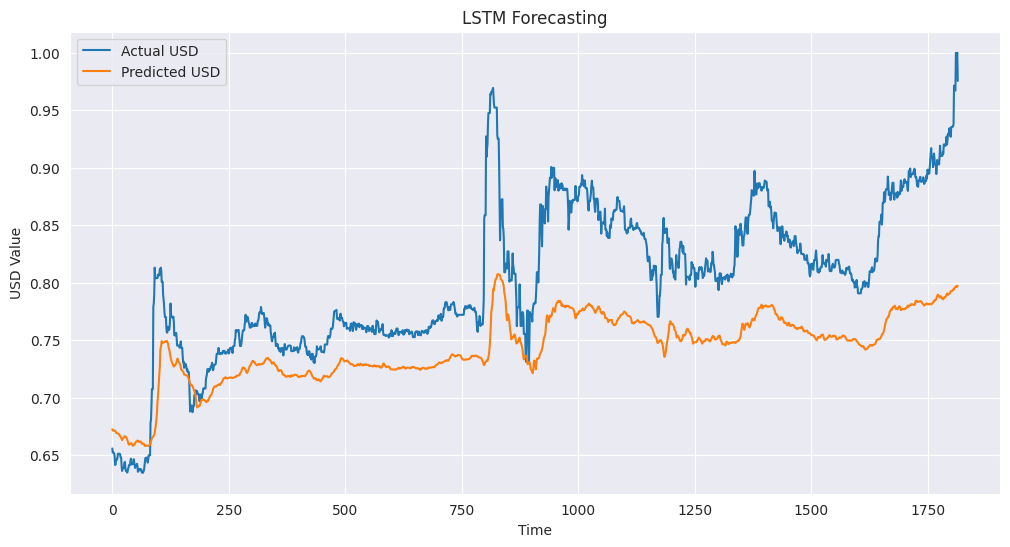

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(actuals_flat, label="Actual USD")
plt.plot(predictions_flat, label="Predicted USD")
plt.legend()
plt.title("LSTM Forecasting")
plt.xlabel("Time")
plt.ylabel("USD Value")
plt.grid(True)
plt.show()

In [41]:
data

,USD,USD(t-1),USD(t-2),USD(t-3),USD(t-4),USD(t-5),USD(t-6),USD(t-7),USD(t-8),USD(t-9),USD(t-10),USD(t-11),USD(t-12),USD(t-13),USD(t-14),USD(t-15)
Date,,,,,,,,,,,,,,,,
2000-01-16,139.40,139.40,138.95,138.95,138.95,138.70,138.70,138.70,138.70,138.20,138.20,138.20,138.20,138.20,138.20,138.20
2000-01-17,139.40,139.40,139.40,138.95,138.95,138.95,138.70,138.70,138.70,138.70,138.20,138.20,138.20,138.20,138.20,138.20
2000-01-18,139.40,139.40,139.40,139.40,138.95,138.95,138.95,138.70,138.70,138.70,138.70,138.20,138.20,138.20,138.20,138.20
2000-01-19,139.50,139.40,139.40,139.40,139.40,138.95,138.95,138.95,138.70,138.70,138.70,138.70,138.20,138.20,138.20,138.20
2000-01-20,139.50,139.50,139.40,139.40,139.40,139.40,138.95,138.95,138.95,138.70,138.70,138.70,138.70,138.20,138.20,138.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03,524.58,511.22,511.22,511.22,513.00,499.51,498.55,498.51,498.34,498.34,498.34,494.87,495.20,497.26,497.89,495.95
2024-12-04,523.17,524.58,511.22,511.22,511.22,513.00,499.51,498.55,498.51,498.34,498.34,498.34,494.87,495.20,497.26,497.89
2024-12-05,523.58,523.17,524.58,511.22,511.22,511.22,513.00,499.51,498.55,498.51,498.34,498.34,498.34,494.87,495.20,497.26
